# PRÀCTICA 1 - REGRESSIÓ

1597487 | Manuel Arnau Fernández

1600123 | Alba Fernández Coronado

1605547 | Marina Palomar González

## 1. Descripció de les dades

In [13]:
# Carregant les llibreries necessàries
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections as col
import scipy.stats as stats
import statsmodels.api as sm
import scipy.stats
import random as rand
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder, StandardScaler, scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , r2_score
import warnings
warnings.filterwarnings("ignore")

In [14]:
# Obrint el dataset
dataset = pd.read_csv('./insurance.csv')
print(f'Mida de les dades: {dataset.shape}')
dataset.head()

Mida de les dades: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [15]:
# Entenent els tipus de variables de cada atribut
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [16]:
# Modificant les dades fent ús de one-hot encoding per tenir-les totes numèriques
dataset_cp = pd.concat([dataset, pd.get_dummies(dataset.region, prefix='region')], axis=1)
dataset_cp = pd.concat([dataset_cp, pd.get_dummies(dataset.smoker, drop_first=True, prefix='smoker')], axis=1)
dataset_cp = pd.concat([dataset_cp, pd.get_dummies(dataset.sex, drop_first=True, prefix='is')], axis=1)
dataset_cp = dataset_cp.drop(['smoker'], axis=1)
dataset_cp = dataset_cp.drop(['sex'], axis=1)
dataset_cp = dataset_cp.drop(['region'], axis=1)
dataset_cp.head()

,age,bmi,children,charges,region_northeast,region_northwest,region_southeast,region_southwest,smoker_yes,is_male
0,19,27.900,0,16884.92400,0,0,0,1,1,0
1,18,33.770,1,1725.55230,0,0,1,0,0,1
2,28,33.000,3,4449.46200,0,0,1,0,0,1
3,33,22.705,0,21984.47061,0,1,0,0,0,1
4,32,28.880,0,3866.85520,0,1,0,0,0,1


In [17]:
# Separant el dataset en X i Y
Y = dataset_cp['charges']
X = dataset_cp.drop(['charges'], axis=1)

### ANÀLISI DELS ATRIBUTS

Southwest: 325, Southeast: 364, Northeast: 324, Northwest: 325


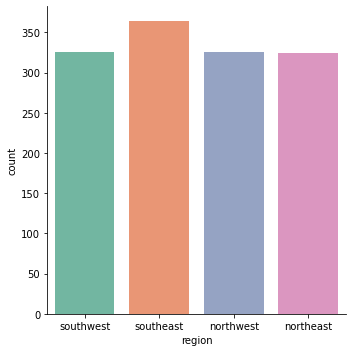

In [18]:
# Estudi de l'atribut region
sns.catplot(x = "region", data = dataset, kind = "count", palette='Set2')
count = col.Counter(dataset['region'])
sw = count['southwest']
se = count['southeast']
ne = count['northeast']
nw = count['northwest']
print(f'Southwest: {sw}, Southeast: {se}, Northeast: {ne}, Northwest: {nw}')

Zero fills: 574, Un fill: 324, Dos fills: 240, Tres fills: 157, Quatre fills: 25, Cinc fills: 18


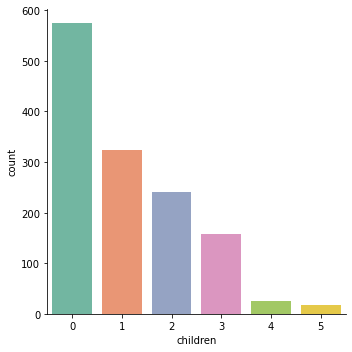

In [19]:
# Estudi de l'atribut children
sns.catplot(x = "children", data = dataset, kind = "count", palette='Set2')
count = col.Counter(dataset['children'])
z = count[0]
u = count[1]
d = count[2]
t = count[3]
q = count[4]
c = count[5]
print(f'Zero fills: {z}, Un fill: {u}, Dos fills: {d}, Tres fills: {t}, Quatre fills: {q}, Cinc fills: {c}')

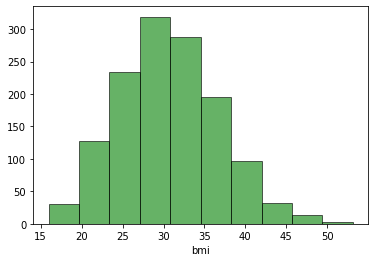

<AxesSubplot:xlabel='bmi', ylabel='Density'>

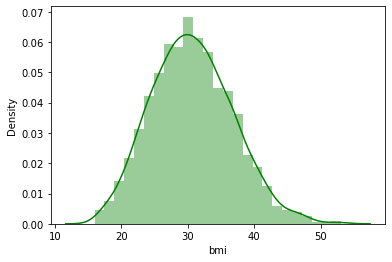

In [20]:
# Estudi de l'atribut BMI
plt.hist(dataset['bmi'], color= 'green', edgecolor = 'black', alpha = 0.6)
plt.xlabel('bmi')
plt.show()

sns.distplot(dataset['bmi'], color= 'green')

Nombre total outliers en la distribució BMI: 9.


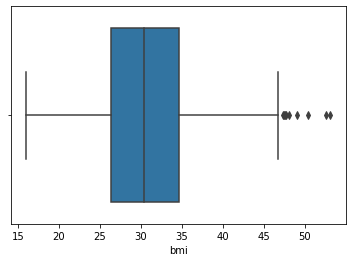

In [21]:
# Realitzant un boxplot d'aquesta variable per tal d'analitzar els outliers
sns.boxplot(dataset['bmi'])
Q1 = dataset['bmi'].quantile(0.25)
Q3 = dataset['bmi'].quantile(0.75)
IQR = Q3 - Q1
total_outlier_num = ((dataset['bmi'] < (Q1 - 1.5 * IQR)) | (dataset['bmi'] > (Q3 + 1.5 * IQR))).sum()
print(f'Nombre total outliers en la distribució BMI: {total_outlier_num}.')

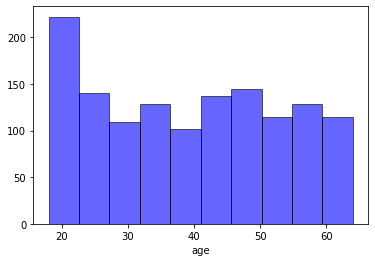

<AxesSubplot:xlabel='age', ylabel='Density'>

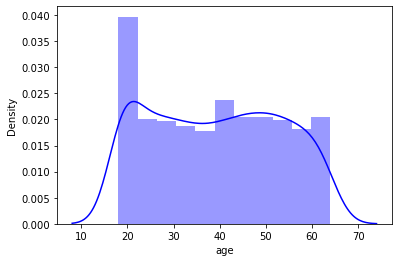

In [22]:
# Estudi de l'atribut age
plt.hist(dataset['age'], color= 'blue', edgecolor = 'black', alpha = 0.6)
plt.xlabel('age')
plt.show()

sns.distplot(dataset['age'], color= 'blue')

Homes: 676, Dones: 662


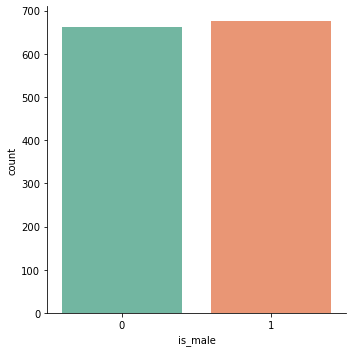

In [23]:
# Estudi de l'atribut sex (0 = dona, 1 = home)
sns.catplot(x = "is_male", data = X, kind = "count", palette='Set2')
count = col.Counter(X['is_male'])
female = count[0]
male = count[1]
print(f'Homes: {male}, Dones: {female}')

No fumadors: 1064, Fumadors: 274


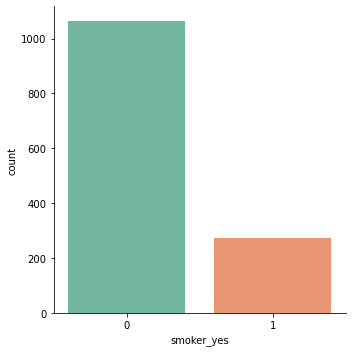

In [24]:
# Estudi de l'atribut smoker (0 = no fumador, 1 = fumador)
sns.catplot(x = "smoker_yes", data = X, kind = "count", palette='Set2')
count = col.Counter(X['smoker_yes'])
no_s = count[0]
s = count[1]
print(f'No fumadors: {no_s}, Fumadors: {s}')

### INFORMACIÓ DE LA VARIABLE RESPOSTA

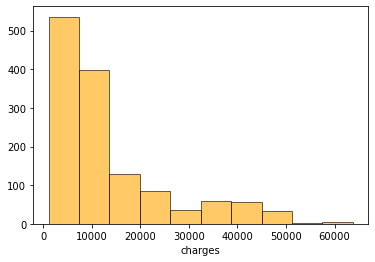

<AxesSubplot:xlabel='charges', ylabel='Density'>

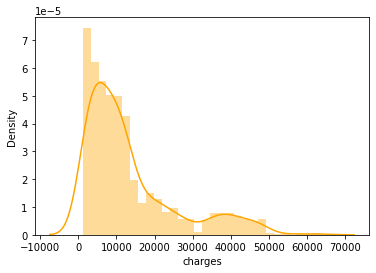

In [25]:
# Estudi de la variable resposta, charges
plt.hist(Y, color= 'orange', edgecolor = 'black', alpha = 0.6)
plt.xlabel('charges')
plt.show()
sns.distplot(Y, color= 'orange')

Nombre total outliers en la distribució CHARGES: 139.


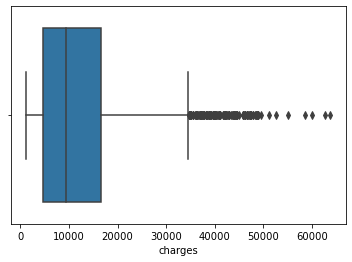

In [26]:
# Realitzant un boxplot d'aquesta variable per tal d'analitzar els outliers
sns.boxplot(Y)
Q1 = Y.quantile(0.25)
Q3 = Y.quantile(0.75)
IQR = Q3 - Q1
total_outlier_num = ((Y < (Q1 - 1.5 * IQR)) | (Y > (Q3 + 1.5 * IQR))).sum()
print(f'Nombre total outliers en la distribució CHARGES: {total_outlier_num}.')

### ANÀLISI DELS ATRIBUTS RESPECTE LA VARIABLE RESPOSTA

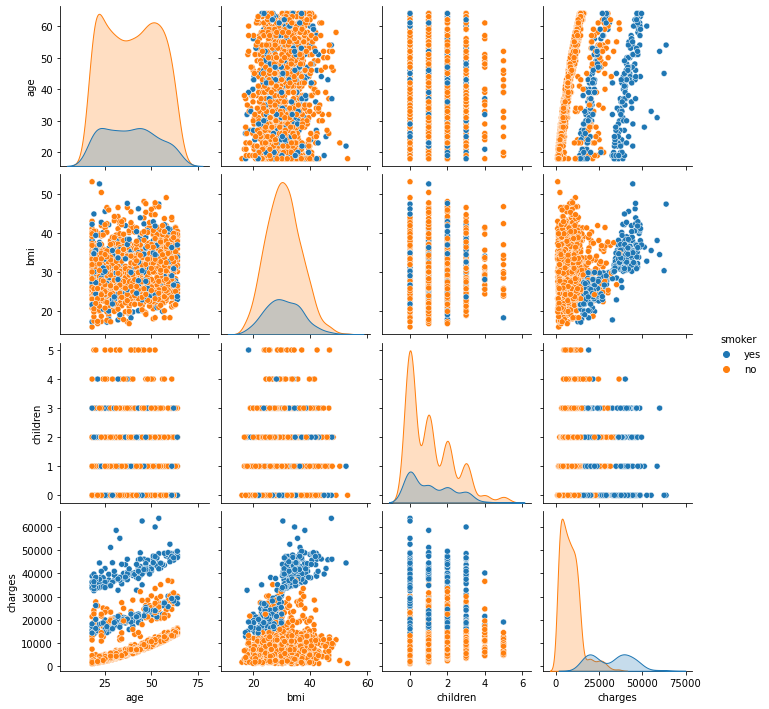

In [273]:
# Es tracen relacions per parelles d'atributs no binaris tenint en compte si fumen
sns.pairplot(dataset, hue = 'smoker')

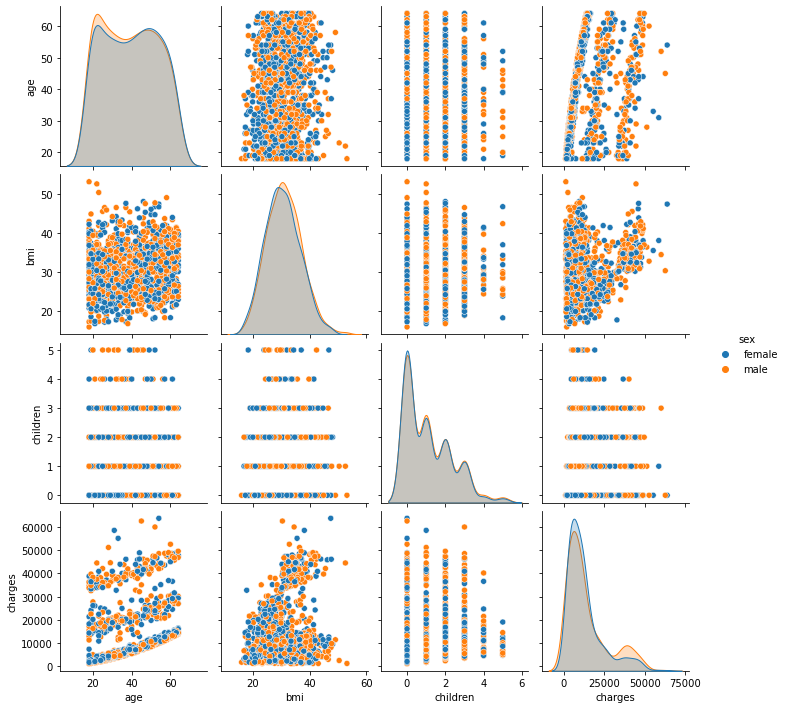

In [28]:
# Es tracen relacions per parelles d'atributs no binaris tenint en compte el gènere
sns.pairplot(dataset, hue = 'sex')

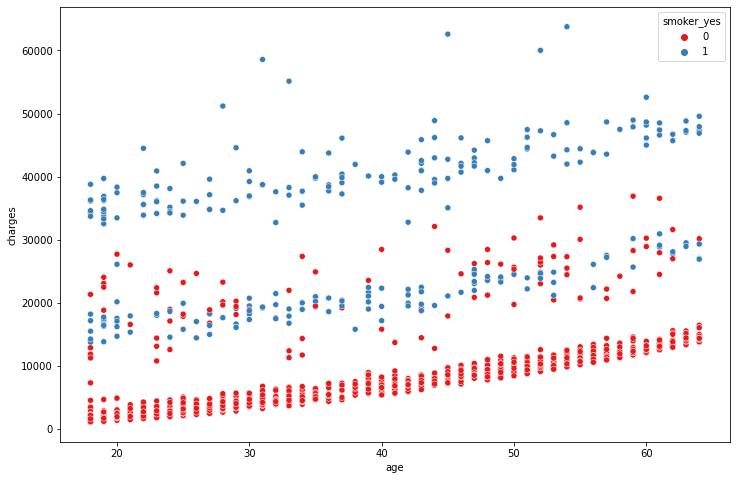

In [29]:
# Comparació edat i preus segons si són fumadors
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.scatterplot(x = 'age', y = 'charges', hue='smoker_yes', data=dataset_cp, palette='Set1')

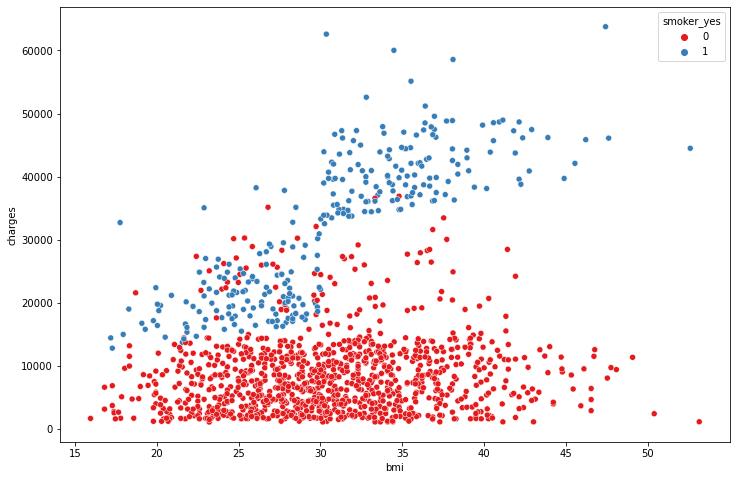

In [30]:
# Comparació bmi i preus segons si són fumadors
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.scatterplot(x = 'bmi', y = 'charges', hue='smoker_yes', data=dataset_cp, palette='Set1')

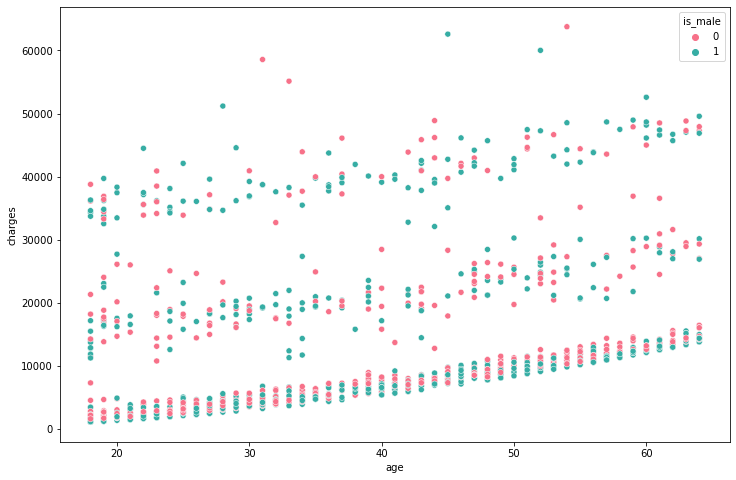

In [31]:
# Comparació edat i preu segons sexe
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.scatterplot(x = 'age', y = 'charges', hue='is_male', data=dataset_cp, palette='husl')

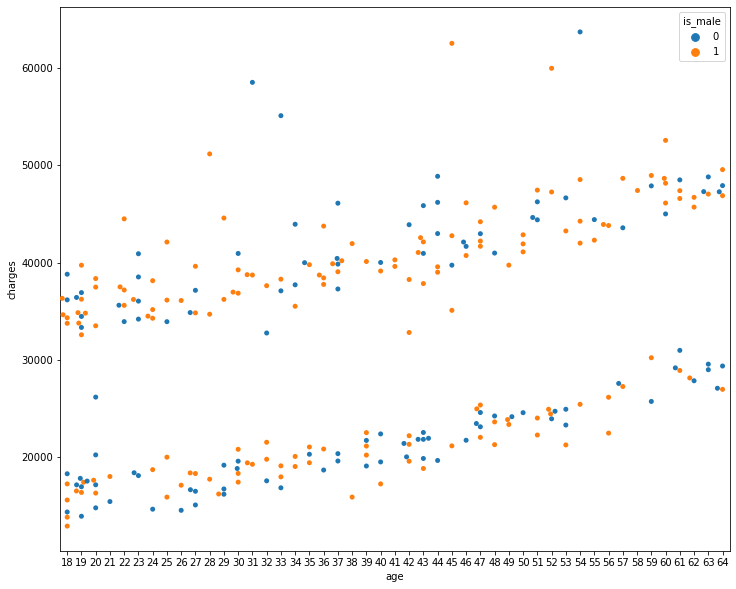

In [32]:
# Còpia de les dades de fumadors a un altre dataset
fumadors = dataset_cp[dataset_cp['smoker_yes'] == 1].copy()

# Comparació de charges respecte el gènere
plt.figure(figsize=(12,10))
sns.swarmplot(y='charges',x='age', hue='is_male',data=fumadors)
plt.show()

In [33]:
# Realització d'un t-test per validar una hipòtesi
H0 = "els homes fumadors paguen més que les dones fumadores"
H1 = "els homes fumadors no paguen més que les dones fumadores"

h = fumadors[fumadors.is_male == 1]['charges']
d = fumadors[fumadors.is_male == 0]['charges']

# Aplicació del test Anova per comparar múltiples mitjanes
f_stat, p_valor = stats.f_oneway(h,d)

if(p_valor<0.05):
    print(f'{p_valor} -> Es rebutja la hipòtesi nul·la, per tant {H1}')
else:
    print(f'{p_valor} -> No es rebutja la hipòtesi nul·la, per tant {H0}') 

0.0944795303099132 -> No es rebutja la hipòtesi nul·la, per tant els homes fumadors paguen més que les dones fumadores


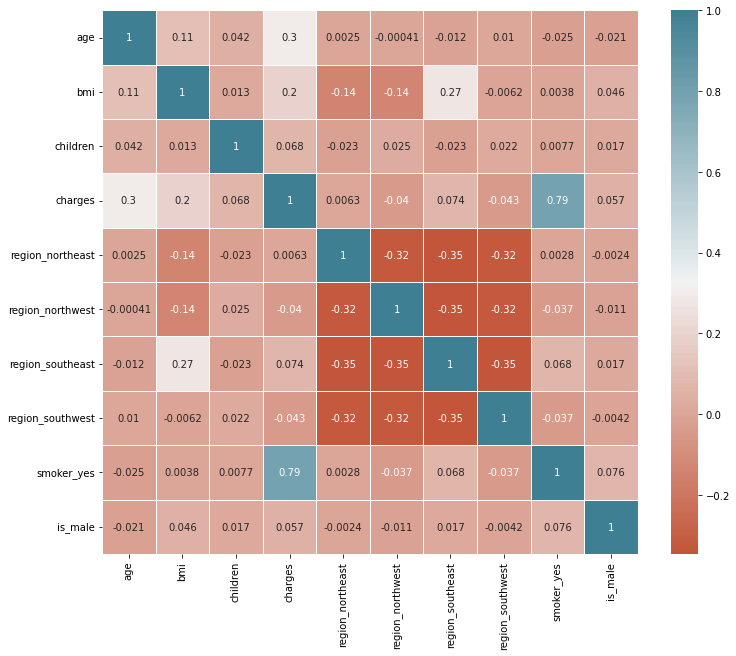

In [34]:
# Estudi de la correlació entre els atributs
correlacio = dataset_cp.corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(correlacio, annot=True, linewidths=.5, cmap = sns.diverging_palette(20, 220, n=200))

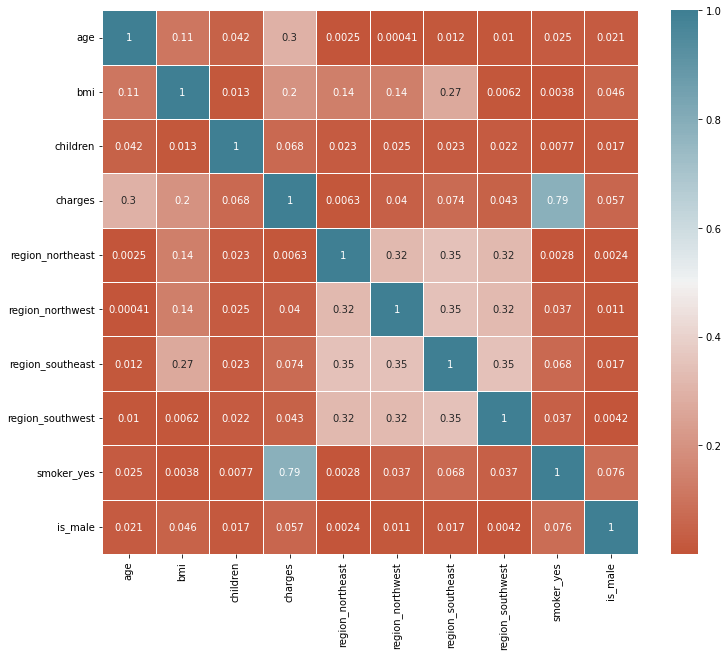

In [35]:
# Es fa el heatmap en valor absolut per veure més clarament les correlacions entre les variables
# El que interessa és saber si les variables estan correlacionades o no, no si ho estan positiva o negativament
correlacio = dataset_cp.corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(abs(correlacio), annot=True, linewidths=.5, cmap = sns.diverging_palette(20, 220, n=200))

## 2. Primeres regressions

In [36]:
# Funció per normalitzar les dades
def standarize(xtrain):
    mean = xtrain.mean(0)
    std = xtrain.std(0)
    x_t = xtrain - mean[None, :]
    x_t /= std[None, :]
    return x_t

In [37]:
# Es faràn dos models de regressió depenent de si l'usuari es fumador o no, per tant es separa el dataset
fumadors = dataset_cp[dataset_cp['smoker_yes'] == 1].copy()
nofumadors = dataset_cp[dataset_cp['smoker_yes'] == 0].copy()
fumadors = fumadors.drop(['smoker_yes'], axis=1)
nofumadors = nofumadors.drop(['smoker_yes'], axis=1)

fy = fumadors['charges']
nfy = nofumadors['charges']
fumadors = fumadors.drop(['charges'], axis=1)
nofumadors = nofumadors.drop(['charges'], axis=1)

fnorm = standarize(fumadors)
nfnorm = standarize(nofumadors)

In [38]:
# Es separen les dades de train i test per ambdós models
XF_train, XF_test, YF_train, YF_test = train_test_split(fnorm, fy, test_size=0.3, random_state=99)
XNF_train, XNF_test, YNF_train, YNF_test = train_test_split(nfnorm, nfy, test_size=0.3, random_state=99)

#### REGRESSIONS SIMPLES

In [123]:
def RegressioSimple(atribut, Xtrain, Ytrain, Xtest, Ytest):
    # Es fa la regressió amb el lm i fit
    lm = LinearRegression()
    np_data=Xtrain[atribut].to_numpy()
    x = np_data.reshape(-1,1)
    model = lm.fit(x,Ytrain)
    m = np.linspace(Xtest[atribut].min(), Xtest[atribut].max(), 100)
    r = [model.coef_ * i + model.intercept_ for i in m]
    
    # Es prediu la variable resposta
    pred = model.coef_ * Xtest[atribut] + model.intercept_ 
    
    # Vector d'errors
    e = Ytest-pred   

    MSE = mean_squared_error(Ytest, pred)
    r2 = r2_score(Ytest, pred)
    
    # Es grafiquen els resultats
    fig = plt.figure(figsize=(12,10))
    gs = gridspec.GridSpec(2, 2)

    ax = fig.add_subplot(gs[0, :])
    sns.scatterplot(y=Ytest,x=Xtest[atribut], hue='is_male', legend=['1','0'],data=Xtest, palette='Set1')
    plt.plot(m, r, 'r')

    ax = fig.add_subplot(gs[1, 0])
    ax.scatter(Ytest,pred)
    ax.set_xlabel('Y')
    ax.set_ylabel('Ypred')
    ax.tick_params(axis='x', rotation=55)

    ax = fig.add_subplot(gs[1, 1])
    ax.scatter(Ytest,e)
    ax.set_xlabel('Y')
    ax.set_ylabel('Error')

    fig.align_labels()

    plt.show()

    print("Mean squeared error: ", MSE)
    print("R2 score: ", r2)

[0.12258223] 10.335939009659699
[-1.4734127  -1.44004057 -1.40666843 -1.37329629 -1.33992415 -1.30655202
 -1.27317988 -1.23980774 -1.2064356  -1.17306347 -1.13969133 -1.10631919
 -1.07294705 -1.03957492 -1.00620278 -0.97283064 -0.9394585  -0.90608637
 -0.87271423 -0.83934209 -0.80596995 -0.77259782 -0.73922568 -0.70585354
 -0.6724814  -0.63910927 -0.60573713 -0.57236499 -0.53899285 -0.50562072
 -0.47224858 -0.43887644 -0.4055043  -0.37213217 -0.33876003 -0.30538789
 -0.27201575 -0.23864362 -0.20527148 -0.17189934 -0.1385272  -0.10515507
 -0.07178293 -0.03841079 -0.00503865  0.02833348  0.06170562  0.09507776
  0.1284499   0.16182203  0.19519417  0.22856631  0.26193845  0.29531058
  0.32868272  0.36205486  0.395427    0.42879913  0.46217127  0.49554341
  0.52891555  0.56228769  0.59565982  0.62903196  0.6624041   0.69577624
  0.72914837  0.76252051  0.79589265  0.82926479  0.86263692  0.89600906
  0.9293812   0.96275334  0.99612547  1.02949761  1.06286975  1.09624189
  1.12961402  1.162

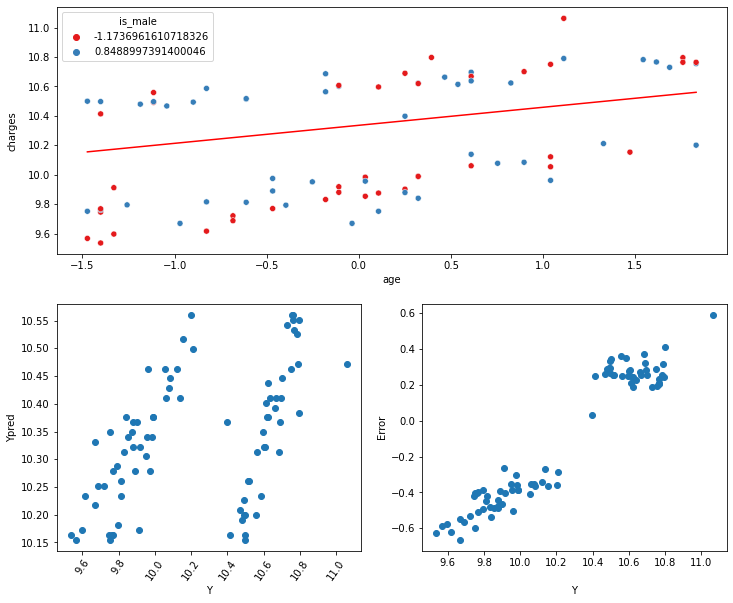

Mean squeared error:  0.14645744503452954
R2 score:  0.12392876066567005


In [124]:
# Regressió de l'atribut age tenint en compte el sexe (vermell = home, blau = dona) sabent que són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimple('age', XF_train, YF_train, XF_test, YF_test)

[0.59281837] 8.792771737390748


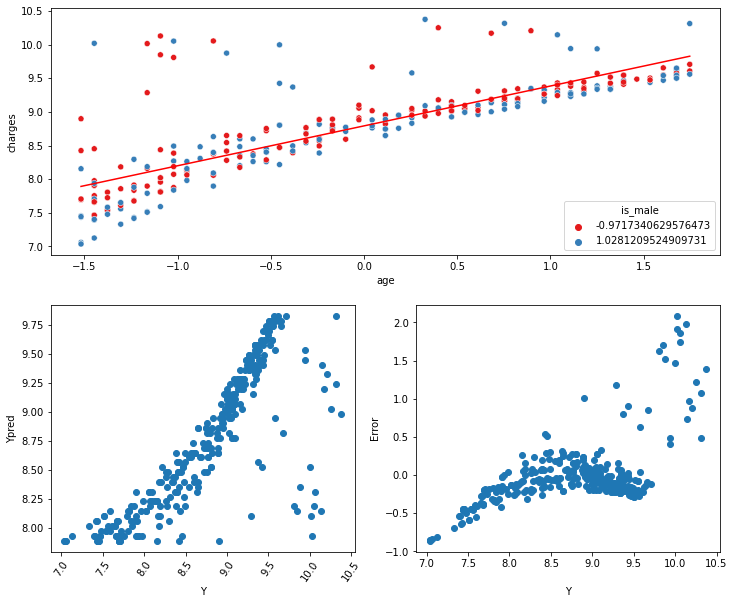

Mean squeared error:  0.18296539338612386
R2 score:  0.6581416033125622


In [118]:
# Regressió de l'atribut age tenint en compte el sexe (vermell = home, blau = dona) sabent que no són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimple('age', XNF_train, YNF_train, XNF_test, YNF_test)

[0.2948818] 10.315033917327815


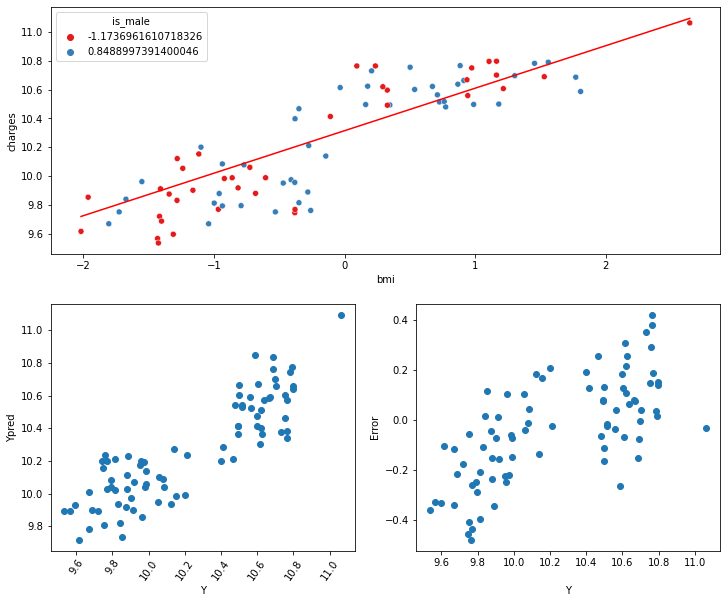

Mean squeared error:  0.04318248617755908
R2 score:  0.7416933350558413


In [119]:
# Regressió de l'atribut bmi tenint en compte el sexe (vermell = home, blau = dona) sabent que són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimple('bmi', XF_train, YF_train, XF_test, YF_test)

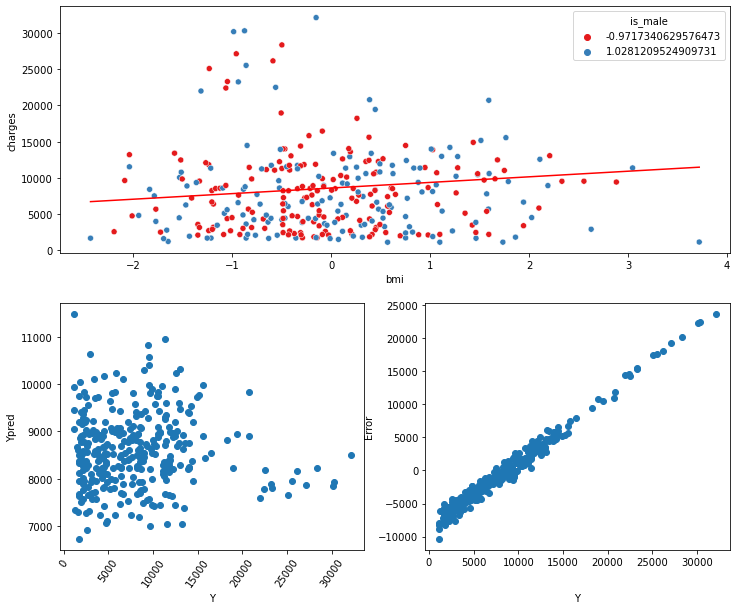

Mean squeared error:  32284086.482694138
R2 score:  -0.03528831983277514


In [43]:
# Regressió de l'atribut bmi tenint en compte el sexe (vermell = home, blau = dona) sabent que no són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimple('bmi', XNF_train, YNF_train, XNF_test, YNF_test)

In [44]:
# Com s'ha pogut observar, el MSE és molt gran així que es fa una transformació logaritmica sobre la resposta
fylog = np.log(fy)
nfylog = np.log(nfy)

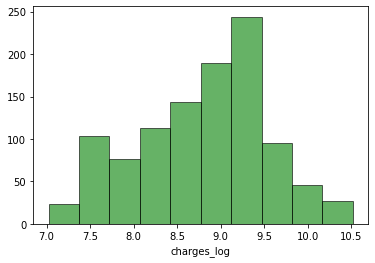

<AxesSubplot:xlabel='charges', ylabel='Density'>

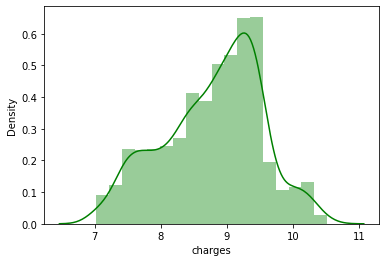

In [45]:
# Estudi de la variable resposta, charges
plt.hist(nfylog, color= 'green', edgecolor = 'black', alpha = 0.6)
plt.xlabel('charges_log')
plt.show()
sns.distplot(nfylog, color= 'green')

In [204]:
# Es torna a separar les dades de train i test amb la nova Y
XF_train, XF_test, YF_train, YF_test = train_test_split(fnorm, fylog, test_size=0.3, random_state=99)
XNF_train, XNF_test, YNF_train, YNF_test = train_test_split(nfnorm, nfylog, test_size=0.3, random_state=99)

[0.12258223] 10.335939009659699
[-1.4734127  -1.44004057 -1.40666843 -1.37329629 -1.33992415 -1.30655202
 -1.27317988 -1.23980774 -1.2064356  -1.17306347 -1.13969133 -1.10631919
 -1.07294705 -1.03957492 -1.00620278 -0.97283064 -0.9394585  -0.90608637
 -0.87271423 -0.83934209 -0.80596995 -0.77259782 -0.73922568 -0.70585354
 -0.6724814  -0.63910927 -0.60573713 -0.57236499 -0.53899285 -0.50562072
 -0.47224858 -0.43887644 -0.4055043  -0.37213217 -0.33876003 -0.30538789
 -0.27201575 -0.23864362 -0.20527148 -0.17189934 -0.1385272  -0.10515507
 -0.07178293 -0.03841079 -0.00503865  0.02833348  0.06170562  0.09507776
  0.1284499   0.16182203  0.19519417  0.22856631  0.26193845  0.29531058
  0.32868272  0.36205486  0.395427    0.42879913  0.46217127  0.49554341
  0.52891555  0.56228769  0.59565982  0.62903196  0.6624041   0.69577624
  0.72914837  0.76252051  0.79589265  0.82926479  0.86263692  0.89600906
  0.9293812   0.96275334  0.99612547  1.02949761  1.06286975  1.09624189
  1.12961402  1.162

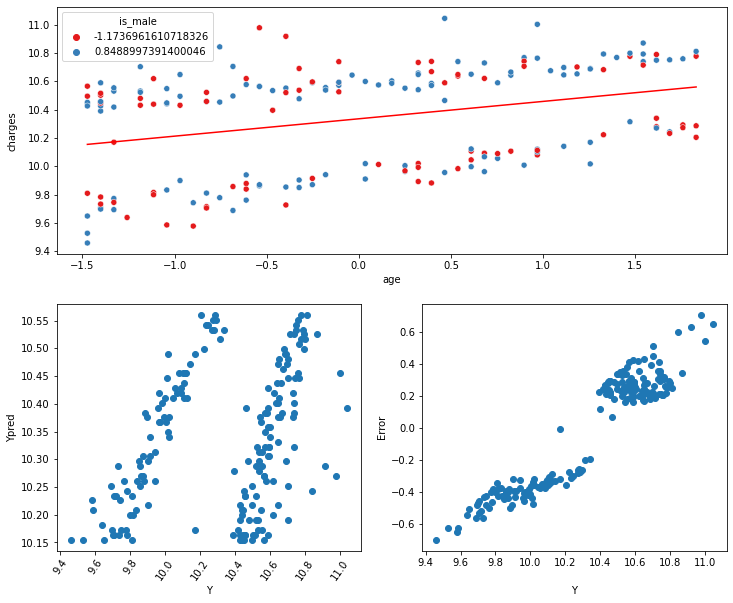

Mean squeared error:  0.12340147545184388
R2 score:  0.1108205585826475


In [205]:
# Regressió de l'atribut age tenint en compte el sexe (vermell = home, blau = dona) sabent que són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimple('age', XF_train, YF_train, XF_train, YF_train)

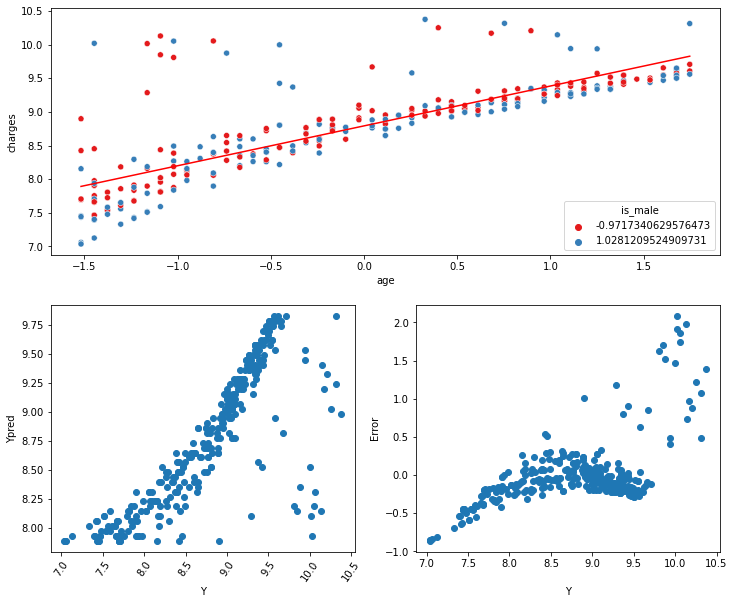

Mean squeared error:  0.18296539338612386
R2 score:  0.6581416033125622


In [48]:
# Regressió de l'atribut age tenint en compte el sexe (vermell = home, blau = dona) sabent que no són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimple('age', XNF_train, YNF_train, XNF_test, YNF_test)

[0.2948818] 10.315033917327815


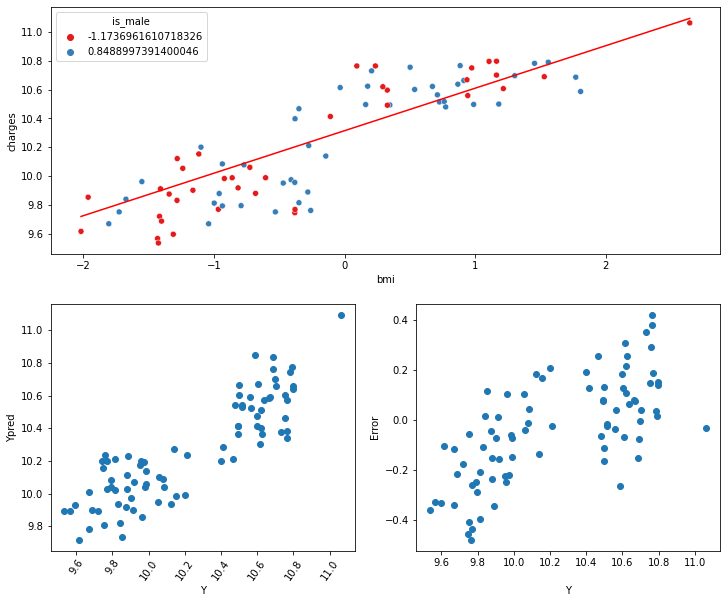

Mean squeared error:  0.04318248617755908
R2 score:  0.7416933350558413


In [120]:
# Regressió de l'atribut bmi tenint en compte el sexe (vermell = home, blau = dona) sabent que són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimple('bmi', XF_train, YF_train, XF_test, YF_test)

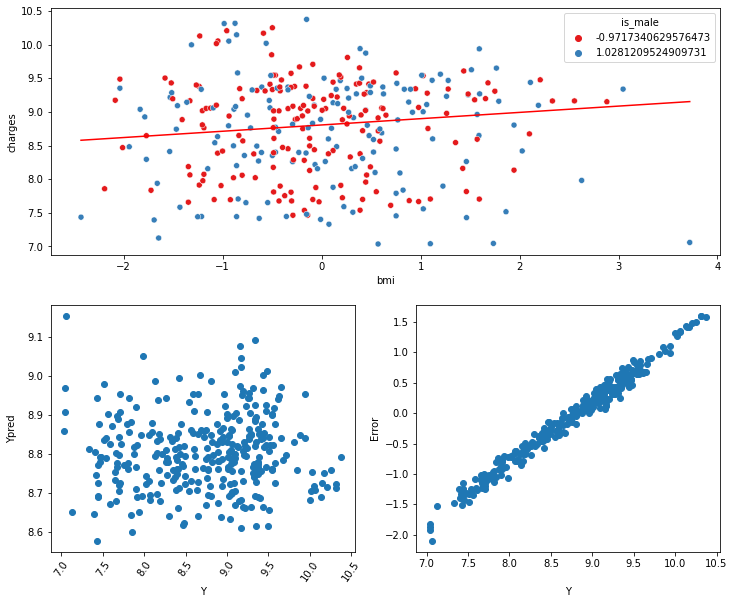

Mean squeared error:  0.5456084268138688
R2 score:  -0.019432246491101646


In [50]:
# Regressió de l'atribut bmi tenint en compte el sexe (vermell = home, blau = dona) sabent que no són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimple('bmi', XNF_train, YNF_train, XNF_test, YNF_test)

#### REGRESSIONS MÚLTIPLES

In [51]:
# Realitzant una regressió lineal amb lm sobre el dataset de fumadors
lmF = LinearRegression()
modelFumadors = lmF.fit(XF_train,YF_train)
predFumadors = lmF.predict(XF_test) 
pd.DataFrame(modelFumadors.coef_, fumadors.columns, columns=["Coeff"])

,Coeff
age,0.122115
bmi,0.302756
children,-0.003997
region_northeast,0.010059
region_northwest,0.005667
region_southeast,-0.021924
region_southwest,0.009026
is_male,0.000398


In [52]:
print('intercept:',modelFumadors.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(YF_test, predFumadors))
print('Coefficient of determination (R^2): %.2f'% r2_score(YF_test, predFumadors))

intercept: 10.316357031920287
Mean squared error (MSE): 0.03
Coefficient of determination (R^2): 0.84


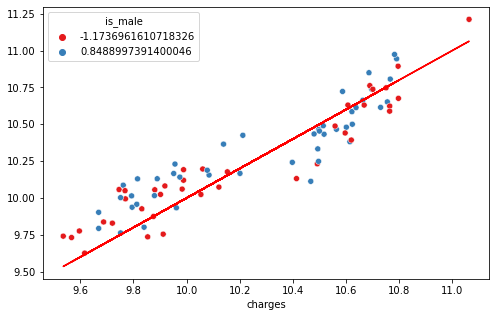

In [53]:
# Es grafiquen Ypred-Y tenint en compte el sexe sabent que són fumadors
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=predFumadors,x=YF_test, hue='is_male',data=XF_test, palette='Set1')
plt.plot(YF_test, YF_test, 'r') # recta amb pendent 1, per veure com de bona es ypred
plt.show()

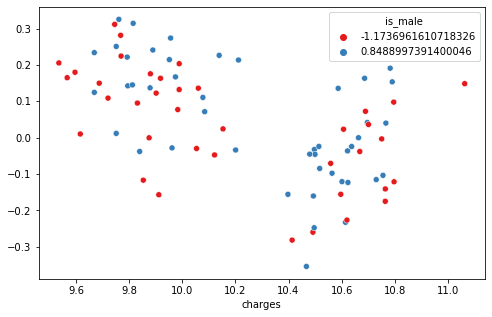

In [54]:
# Es grafiquen Error-Y tenint en compte el sexe sabent que són fumadors
ErrorF = list(predFumadors - YF_test)
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=ErrorF,x=YF_test, hue='is_male',data=XF_test, palette='Set1')
plt.show()

In [55]:
# Realitzant una regressió lineal amb lm sobre el dataset de no fumadors
lmNF = LinearRegression()
modelNoFumadors = lmNF.fit(XNF_train,YNF_train)
predNoFumadors = lmNF.predict(XNF_test)
pd.DataFrame(modelNoFumadors.coef_, nofumadors.columns, columns=["Coeff"])

,Coeff
age,0.579605
bmi,0.034551
children,0.160532
region_northeast,0.046543
region_northwest,0.018731
region_southeast,-0.028428
region_southwest,-0.036043
is_male,-0.053813


In [56]:
print('intercept:',modelNoFumadors.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(YNF_test, predNoFumadors))
print('Coefficient of determination (R^2): %.2f'% r2_score(YNF_test, predNoFumadors))

intercept: 8.797546297867141
Mean squared error (MSE): 0.16
Coefficient of determination (R^2): 0.71


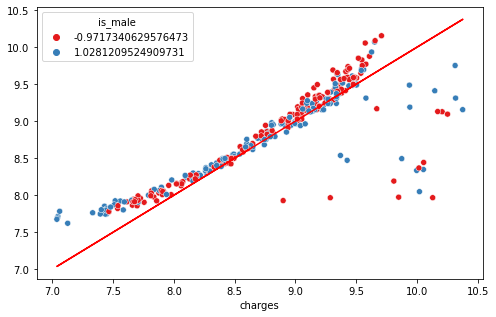

In [57]:
# Es grafiquen Ypred-Y tenint en compte el sexe sabent que són no fumadors
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=predNoFumadors,x=YNF_test, hue='is_male',data=XNF_test, palette='Set1')
plt.plot(YNF_test, YNF_test, 'r')
plt.show()

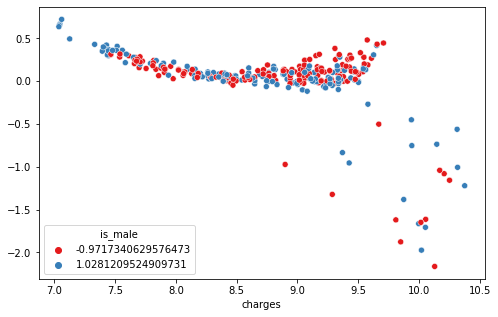

In [58]:
# Es grafiquen Error-Y tenint en compte el sexe sabent que són no fumadors
ErrorNF = list(predNoFumadors - YNF_test)
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=ErrorNF,x=YNF_test, hue='is_male',data=XNF_test, palette='Set1')
plt.show()

In [59]:
# Es realitza una altra regressió múltiple per quedar-se amb els atributs més influents
def RegressioMultiple(Xtrain, Ytrain,it=0):
    if(it == 0):
        # Afegeix intercept al model
        Xtrain = sm.add_constant(Xtrain)
        it = it + 1
    # Realitzant una regressió lineal amb OLS
    model = sm.OLS(Ytrain,Xtrain)
    resultat = model.fit()
    if resultat.pvalues.max() > 0.05:
        resultat = BWSelection(it,resultat, Xtrain, Ytrain)
    return(resultat)

In [60]:
# Es realitza un backward Selection
def BWSelection(it,resultat, Xtrain, Ytrain):
    index = list(resultat.pvalues).index(resultat.pvalues.max())
    Xtrain = Xtrain.drop(Xtrain.columns[index], axis=1)
    res = RegressioMultiple(Xtrain, Ytrain,it)
    return(res)

In [61]:
FMultiple = RegressioMultiple(XF_train, YF_train)
NFMultiple = RegressioMultiple(XNF_train, YNF_train)

In [62]:
FMultiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     148.0
Date:                Fri, 07 Oct 2022   Prob (F-statistic):           3.75e-49
Time:                        12:47:42   Log-Likelihood:                 33.739
No. Observations:                 191   AIC:                            -59.48
Df Residuals:                     187   BIC:                            -46.47
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.3163      0.015    693.758      0.000      10.287      10.346
age                  0.1215      0.015      8.287      0.000       0.093       0.150
bmi                  0.3030      0.016     19.071      0.000       0.272       0.334
region_southeast    -0.0313      0.015     -2.053      0.041      -0.061      -0.001
==============================================================================
Omnibus:                       11.219   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.613
Skew:                           0.534   Prob(JB):                      0.00301
Kurtosis:                       3.566   Cond. No.                         1.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
NFMultiple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     260.2
Date:                Fri, 07 Oct 2022   Prob (F-statistic):          2.97e-178
Time:                        12:47:42   Log-Likelihood:                -416.89
No. Observations:                 744   AIC:                             847.8
Df Residuals:                     737   BIC:                             880.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.7980      0.016    563.138      0.000       8.767       8.829
age                  0.5804      0.016     36.620      0.000       0.549       0.612
bmi                  0.0347      0.017      2.079      0.038       0.002       0.067
children             0.1601      0.016      9.950      0.000       0.129       0.192
region_southeast    -0.0618      0.017     -3.542      0.000      -0.096      -0.028
region_southwest    -0.0692      0.017     -4.158      0.000      -0.102      -0.037
is_male             -0.0542      0.016     -3.464      0.001      -0.085      -0.023
==============================================================================
Omnibus:                      458.178   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3333.915
Skew:                           2.829   Prob(JB):                         0.00
Kurtosis:                      11.691   Cond. No.                         1.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### PCA - Principal Component Analysis

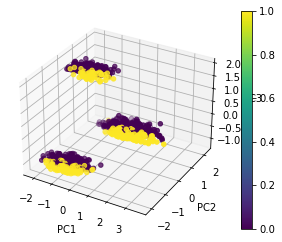

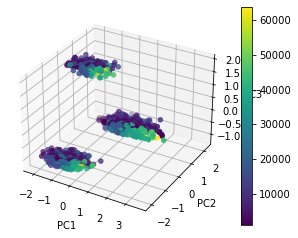

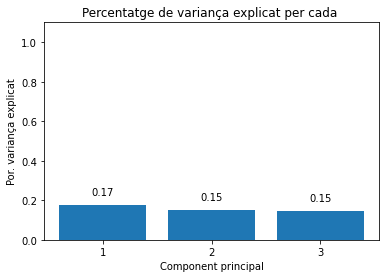

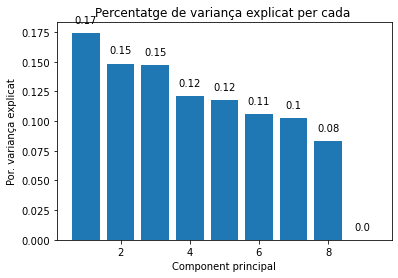

In [64]:
# Es realitza un estudi sobre el PCA
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

model = PCA(n_components=3)
model.fit(X_scaled)
data_pca = pd.DataFrame(
    data = model.components_,
    columns = X.columns,
    index = ['PC1','PC2','PC3'])
X_pca = model.transform(X_scaled)

# Es mira com queda el PCA segons si és fumador
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=X['smoker_yes'])
fig.colorbar(p)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# Es mira com queda el PCA segons la variable resposta
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=Y)
fig.colorbar(p)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# Percentatge de variança de cada component
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(model.n_components_) + 1,
    height = model.explained_variance_ratio_
)

for x, y in zip(np.arange(len(data_pca.columns)) + 1, model.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(model.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Percentatge de variança explicat per cada ')
ax.set_xlabel('Component principal')
ax.set_ylabel('Por. variança explicat');
#SUPER INUTIL, NO EXPLICA RES. AIXÒ ES DEU A QUE LES DADES ESTAN MOLT POC CORRELACIONADES ENTRE ELLES JA DE PER SI

# Generació d'un model amb tots els PCA possibles, per veure quantes dimensions es poden reduïr
model_complet = PCA()
model_complet.fit(X_scaled)

data_pca_complet = pd.DataFrame(
    data = model_complet.components_,
    columns = X.columns,
    index = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9'])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(model_complet.n_components_) + 1,
    height = model_complet.explained_variance_ratio_
)

for x, y in zip(np.arange(len(data_pca_complet.columns)) + 1, model_complet.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
ax.set_title('Percentatge de variança explicat per cada ')
ax.set_xlabel('Component principal')
ax.set_ylabel('Por. variança explicat');
plt.show()

## 3. Descens del gradient

### Regressions Simples

In [304]:
XF_train, XF_test, YF_train, YF_test = train_test_split(fnorm, fylog, test_size=0.3, random_state=99)
XNF_train, XNF_test, YNF_train, YNF_test = train_test_split(nfnorm, nfylog, test_size=0.3, random_state=99)

In [305]:
class Gradient_Descent(object):
    def __init__(self, parameters,funcio, gradients, learn_ratio, atributs):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.parameters = parameters
        self.funcio = funcio
        self.gradients = gradients
        self.learn_ratio = learn_ratio
        self.atributs = atributs

        
    def predict(self, x):
        x_lista = []
        for i in self.atributs:
            x_lista.append(x[i])
        return self.funcio(self.parameters,x_lista)
    
    def __update(self):
        old_param = self.parameters
        self.parameters[0] = self.parameters[0] - self.learn_ratio*self.gradients[0](old_param,self.x_train,self.y_train)
        for i in range(len(self.parameters)-1):
            self.parameters[i+1] = self.parameters[i+1] - self.learn_ratio*self.gradients[i+1](old_param,self.x_train,self.y_train,self.x_train[i])
        return  1/(2*len(self.y_train)) * sum((self.funcio(self.parameters,self.x_train)-self.y_train)**2)
    
    def train(self, x_train, y_train, max_iter, epsilon):
        self.x_train = []
        for i in self.atributs:
            self.x_train.append(x_train[i])
        self.y_train = y_train
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.n_iter = 0
        old_cost_function = 1/(2*len(y_train)) * sum((self.funcio(self.parameters,self.x_train)-y_train)**2)
        new_cost_function = 0
        dif = old_cost_function - new_cost_function
        while np.abs(dif) > epsilon and self.n_iter < max_iter:
            new_cost_function=self.__update()
            dif = old_cost_function - new_cost_function
            old_cost_function = new_cost_function
            self.n_iter = self.n_iter + 1


In [306]:
def f(parameters,x):
    return parameters[0] + parameters[1]*x[0]

def grad1(parameters,x,y):
    return sum(parameters[0]+parameters[1]*x[0] - y)/len(y)

def grad2(parameters,x,y,x_esp):
    return sum((parameters[0]+parameters[1]*x[0] - y)*x_esp)/len(y)

def RegressioSimpleGD(learning_ratio, max_it, epsilon, atribut, Xtrain, Ytrain, Xtest, Ytest):
    # Es fa la regressió amb el lm i fit
    w0 = np.random.random()*10
    w1 = np.random.random()
    ratio = learning_ratio
    model=Gradient_Descent([w0,w1],f,[grad1,grad2],ratio,[atribut])

    model.train(Xtrain,Ytrain, 1000, 0.0001)
    m = np.linspace(Xtest[atribut].min(), Xtest[atribut].max(), 100)
    r = [model.parameters[1] * i + model.parameters[0] for i in m]
    
    # Es prediu la variable resposta
    pred = model.predict(Xtest)
    # Vector d'errors
    e = Ytest-pred   

    MSE = mean_squared_error(Ytest, pred)
    r2 = r2_score(Ytest, pred)
    
    # Es grafiquen els resultats
    fig = plt.figure(figsize=(12,10))
    gs = gridspec.GridSpec(2, 2)

    ax = fig.add_subplot(gs[0, :])
    sns.scatterplot(y=Ytest,x=Xtest[atribut], hue='is_male', legend=['1','0'],data=Xtest, palette='Set1')
    plt.plot(m, r, 'r')

    ax = fig.add_subplot(gs[1, 0])
    ax.scatter(Ytest,pred)
    ax.set_xlabel('Y')
    ax.set_ylabel('Ypred')
    ax.tick_params(axis='x', rotation=55)

    ax = fig.add_subplot(gs[1, 1])
    ax.scatter(Ytest,e)
    ax.set_xlabel('Y')
    ax.set_ylabel('Error')

    fig.align_labels()

    plt.show()

    print("Mean squeared error: ", MSE)
    print("R2 score: ", r2)
    print("Número d'iteracions:",model.n_iter)

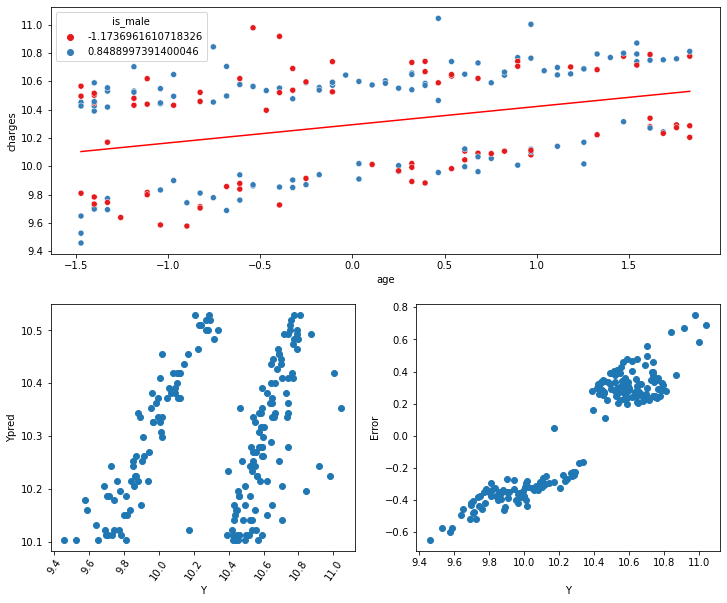

Mean squeared error:  0.12518281518966046
R2 score:  0.09798496916002031
Número d'iteracions: 66


In [307]:
# Regressió de l'atribut age tenint en compte el sexe (vermell = home, blau = dona) sabent que són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimpleGD(0.05,1000, 0.000001, 'age', XF_train, YF_train, XF_train, YF_train)

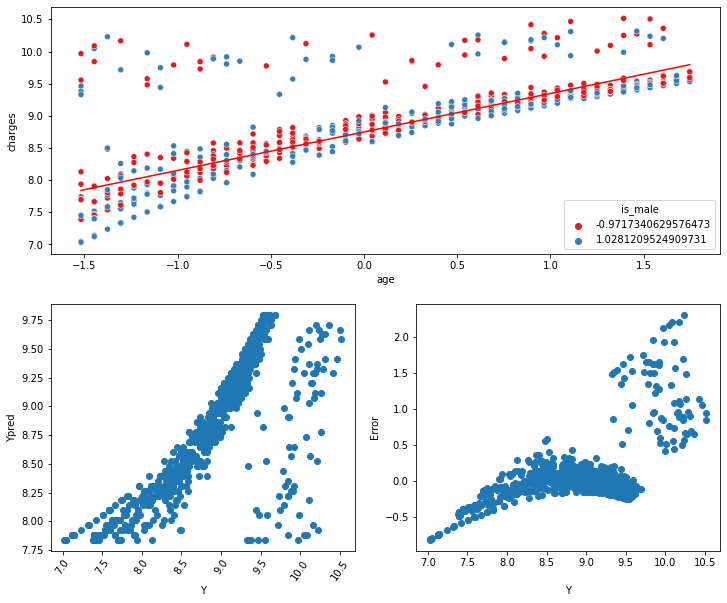

Mean squeared error:  0.21449065078084895
R2 score:  0.6169949008968432
Número d'iteracions: 80


In [308]:
# Regressió de l'atribut age tenint en compte el sexe (vermell = home, blau = dona) sabent que no són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimpleGD(0.05,1000, 0.000001, 'age', XNF_train, YNF_train, XNF_train, YNF_train)

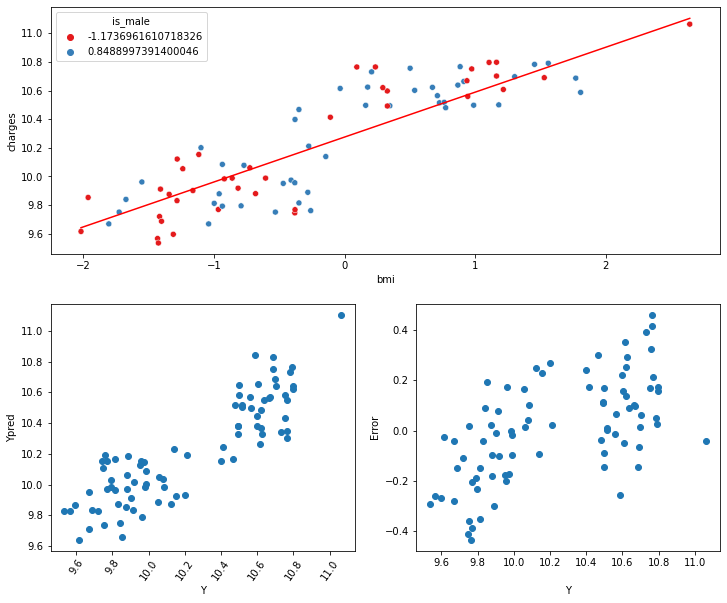

Mean squeared error:  0.04038123218491899
R2 score:  0.7584497249849695
Número d'iteracions: 106


In [309]:
RegressioSimpleGD(0.05, 1000, 0.000001, 'bmi', XF_train, YF_train, XF_test, YF_test)

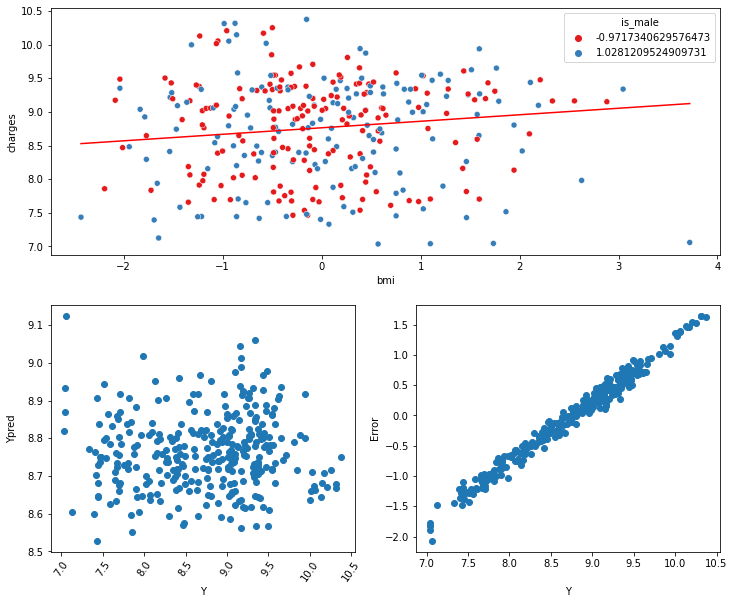

Mean squeared error:  0.5428685418697681
R2 score:  -0.0143129577733625
Número d'iteracions: 90


In [310]:
# Regressió de l'atribut bmi tenint en compte el sexe (vermell = home, blau = dona) sabent que no són fumadors
# També es grafiquen Ypred-Y i Error-Y
RegressioSimpleGD(0.05,1000,0.000001,'bmi', XNF_train, YNF_train, XNF_test, YNF_test)

### Regressió Múltiple

In [311]:
lmF = LinearRegression()
modelFumadors = lmF.fit(XF_train,YF_train)
predFumadors = lmF.predict(XF_test) 
pd.DataFrame(modelFumadors.coef_, fumadors.columns, columns=["Coeff"])


,Coeff
age,0.122115
bmi,0.302756
children,-0.003997
region_northeast,0.010059
region_northwest,0.005667
region_southeast,-0.021924
region_southwest,0.009026
is_male,0.000398


In [312]:
def f(p,x):
    return p[0] + p[1]*x[0] + p[2]*x[1] + p[3]*x[2] + p[4]*x[3] + p[5]*x[4] + p[6]*x[5] + p[7]*x[6] + p[8]*x[7] 

def grad1(p,x,y,x_esp=0):
    return sum(p[0] + p[1]*x[0] + p[2]*x[1] + p[3]*x[2] + p[4]*x[3] + p[5]*x[4] + p[6]*x[5] + p[7]*x[6] + p[8]*x[7]  - y)/len(y)

def grad2(p,x,y,x_esp):
    return sum((p[0] + p[1]*x[0] + p[2]*x[1] + p[3]*x[2] + p[4]*x[3] + p[5]*x[4] + p[6]*x[5] + p[7]*x[6] + p[8]*x[7]  - y)*x_esp)/len(y)


gradient = [grad1, grad2, grad2, grad2, grad2, grad2, grad2, grad2, grad2]
param = []
for i in range(9):
    param.append(np.random.random())
ratio = 0.05
atributs = ["age","bmi","children","region_northeast","region_northwest","region_southeast","region_southwest","is_male"]



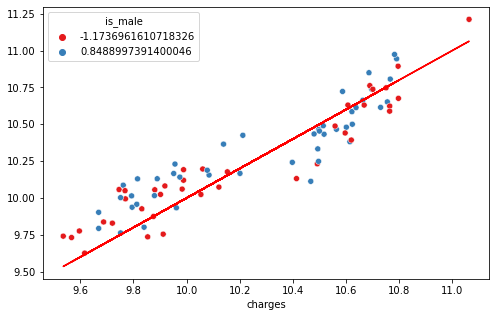

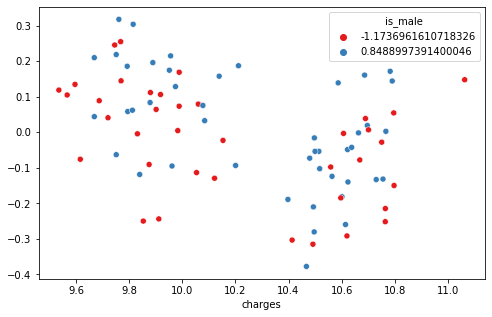

Mean squared error (MSE): 0.03
Coefficient of determination (R^2): 0.85
Número d'iteracions: 110


In [313]:
#FUMADORS

modelF=Gradient_Descent(param,f,gradient,ratio, atributs)
modelF.train(XF_train,YF_train, 1000, 0.0001)

predF = modelF.predict(XF_test)

# Es grafiquen Ypred-Y tenint en compte el sexe sabent que són fumadors
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=predFumadors,x=YF_test, hue='is_male',data=XF_test, palette='Set1')
plt.plot(YF_test, YF_test, 'r') # recta amb pendent 1, per veure com de bona es ypred
plt.show()


ErrorF = list(predF - YF_test)
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=ErrorF,x=YF_test, hue='is_male',data=XF_test, palette='Set1')
plt.show()
print('Mean squared error (MSE): %.2f' % mean_squared_error(YF_test, predF))
print('Coefficient of determination (R^2): %.2f'% r2_score(YF_test, predF))
print("Número d'iteracions:",modelF.n_iter)

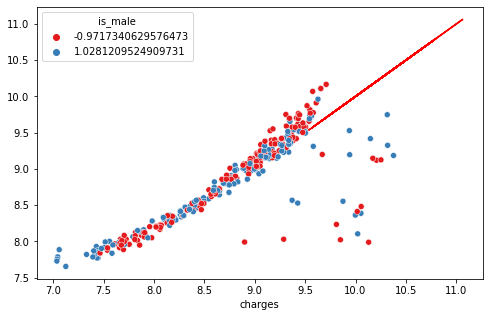

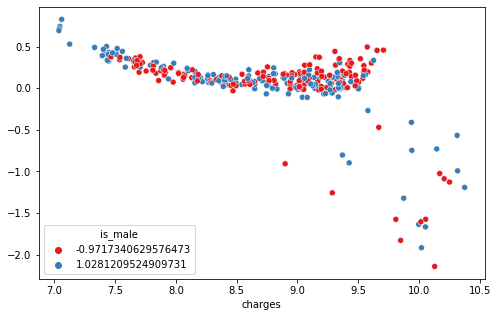

Mean squared error (MSE): 0.16
Coefficient of determination (R^2): 0.69
Número d'iteracions: 72


In [314]:
#NO FUMADORS

modelNF=Gradient_Descent(param,f,gradient,ratio, atributs)
modelNF.train(XNF_train,YNF_train, 1000, 0.0001)

predNF = model.predict(XNF_test)


# Es grafiquen Ypred-Y tenint en compte el sexe sabent que no són fumadors
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=predNF,x=YNF_test, hue='is_male',data=XNF_test, palette='Set1')
plt.plot(YF_test, YF_test, 'r') # recta amb pendent 1, per veure com de bona es ypred
plt.show()


ErrorNF = list(predNF - YNF_test)
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=ErrorNF,x=YNF_test, hue='is_male',data=XNF_test, palette='Set1')
plt.show()
print('Mean squared error (MSE): %.2f' % mean_squared_error(YNF_test, predNF))
print('Coefficient of determination (R^2): %.2f'% r2_score(YNF_test, predNF))
print("Número d'iteracions:",modelNF.n_iter)

### Nous models


In [354]:
#Model per a fumadors amb bmi i edat només
#w0 + w1*edat + w2*bmi + w3*bmi^2 + w4*bmi^3
def f(p,x):
    return p[0] + p[1]*x[0] + p[2]*x[1] + p[3]*x[2]*x[2] + p[4]*x[3]**3

def grad1(p,x,y,x_esp=0):
    return sum(p[0] + p[1]*x[0] + p[2]*x[1] + p[3]*x[2]*x[2] + p[4]*x[3]**3 - y)/len(y)
def grad2(p,x,y,x_esp):
    return sum((p[0] + p[1]*x[0] + p[2]*x[1] + p[3]*x[2]*x[2] + p[4]*x[3]**3 - y)*x_esp)/len(y)
def grad3(p,x,y,x_esp):
    return sum((p[0] + p[1]*x[0] + p[2]*x[1] + p[3]*x[2]*x[2] + p[4]*x[3]**3 - y)*x_esp*x_esp)/len(y)
def grad4(p,x,y,x_esp):
    return sum((p[0] + p[1]*x[0] + p[2]*x[1] + p[3]*x[2]*x[2] + p[4]*x[3]**3 - y)*x_esp*x_esp*x_esp)/len(y)

gradient = [grad1, grad2, grad2, grad3, grad4]
param = []
for i in range(5):
    param.append(np.random.random())
ratio = 0.05
atributs = ["age","bmi","bmi","bmi"]

modelF=Gradient_Descent(param,f,gradient,ratio, atributs)
modelF.train(XF_train,YF_train, 1000, 0.00001)

modelF.parameters

[10.314826131465912,
 0.11613985958222514,
 0.42151936491974307,
 0.0035030474910524977,
 -0.03650789456033022]

327     10.729047
49      10.582141
263     10.536907
793      9.926329
1188    10.015313
          ...    
966     10.057478
545     10.096292
224      9.974642
64       9.695890
886     10.354400
Length: 83, dtype: float64


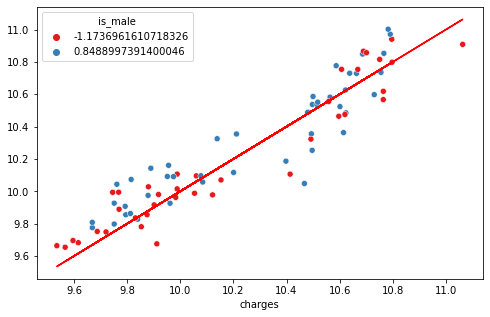

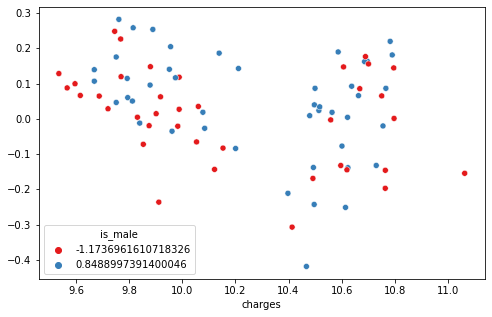

Mean squared error (MSE): 0.02
Coefficient of determination (R^2): 0.88
Número d'iteracions: 242


In [355]:
predF = modelF.predict(XF_test)
print(predF)
# Es grafiquen Ypred-Y tenint en compte el sexe sabent que són fumadors
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=predF,x=YF_test, hue='is_male',data=XF_test, palette='Set1')
plt.plot(YF_test, YF_test, 'r') # recta amb pendent 1, per veure com de bona es ypred
plt.show()


ErrorF = list(predF - YF_test)
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=ErrorF,x=YF_test, hue='is_male',data=XF_test, palette='Set1')
plt.show()

print('Mean squared error (MSE): %.2f' % mean_squared_error(YF_test, predF))
print('Coefficient of determination (R^2): %.2f'% r2_score(YF_test, predF))
print("Número d'iteracions:",modelF.n_iter)

In [358]:
#Model per a no fumadors amb edat i fills només
#w0 + w1*edat + w2*edat^2 + w3*children
def f(p,x):
    return p[0] + p[1]*x[0] + p[2]*x[1]*x[1] + p[3]*x[2]
def grad1(p,x,y,x_esp=0):
    return sum(p[0] + p[1]*x[0] + p[2]*x[1]*x[1] + p[3]*x[2] - y)/len(y)
def grad2(p,x,y,x_esp):
    return sum((p[0] + p[1]*x[0] + p[2]*x[1]*x[1] + p[3]*x[2] - y)*x_esp)/len(y)
def grad3(p,x,y,x_esp):
    return sum((p[0] + p[1]*x[0] + p[2]*x[1]*x[1] + p[3]*x[2]- y)*x_esp*x_esp)/len(y)



gradient = [grad1, grad2, grad3, grad2]
param = []
for i in range(4):
    param.append(np.random.random())
ratio = 0.05
atributs = ["age","age","children"]

modelNF=Gradient_Descent(param,f,gradient,ratio, atributs)
modelNF.train(XNF_train,YNF_train, 10000, 0.00001)

modelNF.parameters

[8.806530407794481,
 0.5873591153469954,
 -0.020399191480388663,
 0.15769025700602565]

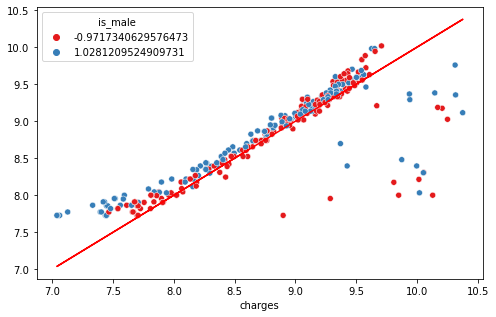

320 320


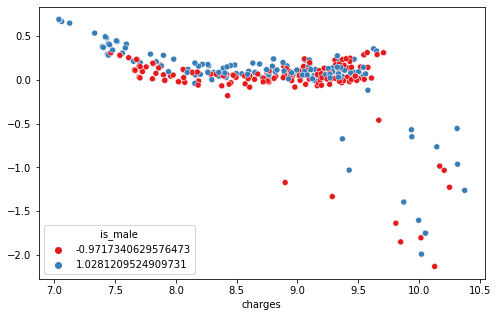

Mean squared error (MSE): 0.16
Coefficient of determination (R^2): 0.71
Número d'iteracions: 350


In [359]:
predNF = modelNF.predict(XNF_test)
# Es grafiquen Ypred-Y tenint en compte el sexe sabent que són fumadors
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=predNF,x=YNF_test, hue='is_male',data=XNF_test, palette='Set1')
plt.plot(YNF_test, YNF_test, 'r') # recta amb pendent 1, per veure com de bona es ypred
plt.show()

print(len(predNF),len(XNF_test))

ErrorNF = list(predNF - YNF_test)
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=ErrorNF,x=YNF_test, hue='is_male',data=XNF_test, palette='Set1')
plt.show()

print('Mean squared error (MSE): %.2f' % mean_squared_error(YNF_test, predNF))
print('Coefficient of determination (R^2): %.2f'% r2_score(YNF_test, predNF))
print("Número d'iteracions:",modelNF.n_iter)